Enter path to your image file: C:\Users\HP\OneDrive\Desktop\ima4.png


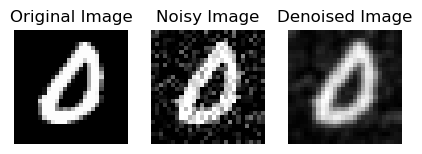

Mean Squared Error (MSE) Gaussian: 0.016427040850923585
Peak Signal-to-Noise Ratio (PSNR) Gaussian: 17.844406628497897
Structural Similarity Index (SSIM) Gaussian: 0.7235715243270744


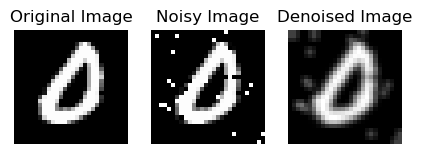

Mean Squared Error (MSE) Salt & Pepper: 0.012731309
Peak Signal-to-Noise Ratio (PSNR) Salt & Pepper: 18.951269393584845
Structural Similarity Index (SSIM) Salt & Pepper: 0.7803920809408527


In [120]:
# Traditional Filters

import numpy as np
from skimage.util import random_noise
from keras.preprocessing import image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def add_gaussian_noise(image, noise_factor=0.2):
    noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    noisy_image = np.clip(noisy_image, 0., 1.)
    return noisy_image

def add_salt_and_pepper_noise(image, noise_amount=0.05):
    noisy_image = image.copy()
    salt_vs_pepper = 0.5
    salt = np.ceil(noise_amount * image.size * salt_vs_pepper)
    pepper = np.ceil(noise_amount * image.size * (1. - salt_vs_pepper))
    
    salt = max(int(salt), 1)
    pepper = max(int(pepper), 1)

    salt_coords = [np.random.randint(0, dim, salt) for dim in image.shape]
    salt_coords = tuple(map(np.array, salt_coords)) 
    noisy_image[salt_coords] = 1

    pepper_coords = [np.random.randint(0, dim, pepper) for dim in image.shape]
    pepper_coords = tuple(map(np.array, pepper_coords)) 
    noisy_image[pepper_coords] = 0

    return noisy_image

image_path = input("Enter path to your image file: ")
img = image.load_img(image_path, target_size=(28, 28), color_mode='grayscale')
img_array = image.img_to_array(img)
img_array /= 255.

gaussian_noisy_img_array = add_gaussian_noise(img_array, noise_factor=noise_factor)
salt_pepper_noisy_img_array = add_salt_and_pepper_noise(img_array, noise_amount=0.05)

denoised_img_array_gaussian = cv2.GaussianBlur(gaussian_noisy_img_array.squeeze(), (3, 3), 0)
denoised_img_array_salt_pepper = cv2.GaussianBlur(salt_pepper_noisy_img_array.squeeze(), (3, 3), 0)

plt.figure(figsize=(5, 4))
plt.subplot(2, 3, 2)
plt.title('Noisy Image')
plt.imshow(gaussian_noisy_img_array.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 1)
plt.title('Original Image')
plt.imshow(img_array.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title('Denoised Image')
plt.imshow(denoised_img_array_gaussian, cmap='gray')
plt.axis('off')
plt.show()

mse_gaussian = np.mean((img_array.squeeze() - denoised_img_array_gaussian) ** 2)
psnr_gaussian = 10 * np.log10((1 ** 2) / mse_gaussian)
ssim_gaussian = ssim(img_array.squeeze(), denoised_img_array_gaussian, data_range=1.0)

print("Mean Squared Error (MSE) Gaussian:", mse_gaussian)
print("Peak Signal-to-Noise Ratio (PSNR) Gaussian:", psnr_gaussian)
print("Structural Similarity Index (SSIM) Gaussian:", ssim_gaussian)

plt.figure(figsize=(5, 4))
plt.subplot(2, 3, 5)
plt.title('Noisy Image')
plt.imshow(salt_pepper_noisy_img_array.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title('Original Image')
plt.imshow(img_array.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.title('Denoised Image')
plt.imshow(denoised_img_array_salt_pepper, cmap='gray')
plt.axis('off')
plt.show()

mse_salt_pepper = np.mean((img_array.squeeze() - denoised_img_array_salt_pepper) ** 2)
psnr_salt_pepper = 10 * np.log10((1 ** 2) / mse_salt_pepper)
ssim_salt_pepper = ssim(img_array.squeeze(), denoised_img_array_salt_pepper, data_range=1.0)

print("Mean Squared Error (MSE) Salt & Pepper:", mse_salt_pepper)
print("Peak Signal-to-Noise Ratio (PSNR) Salt & Pepper:", psnr_salt_pepper)
print("Structural Similarity Index (SSIM) Salt & Pepper:", ssim_salt_pepper)

In [65]:
# Denoising Autoencoder

import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

In [66]:
def add_gaussian_noise(image, noise_factor=0.3):
    noisy_image = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    noisy_image = np.clip(noisy_image, 0., 1.)
    return noisy_image

def add_salt_and_pepper_noise(image, noise_amount=0.05):
    noisy_image = image.copy()
    salt_vs_pepper = 0.5
    salt = np.ceil(noise_amount * image.size * salt_vs_pepper)
    pepper = np.ceil(noise_amount * image.size * (1. - salt_vs_pepper))
    
    salt = max(int(salt), 1)
    pepper = max(int(pepper), 1)

    salt_coords = [np.random.randint(0, dim, salt) for dim in image.shape]
    salt_coords = tuple(map(np.array, salt_coords)) 
    noisy_image[salt_coords] = 1

    pepper_coords = [np.random.randint(0, dim, pepper) for dim in image.shape]
    pepper_coords = tuple(map(np.array, pepper_coords))  
    noisy_image[pepper_coords] = 0

    return noisy_image

In [67]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train_noisy = np.array([add_gaussian_noise(image) for image in x_train])
x_test_noisy = np.array([add_gaussian_noise(image) for image in x_test])

x_train_noisy = np.expand_dims(x_train_noisy, axis=-1)
x_test_noisy = np.expand_dims(x_test_noisy, axis=-1)

input_img = Input(shape=(28, 28, 1))
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=64,
                shuffle=True)


Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 108s 111ms/step - loss: 0.1445
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 101s 107ms/step - loss: 0.0817
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 102s 108ms/step - loss: 0.0791
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 104s 111ms/step - loss: 0.0778
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 101s 108ms/step - loss: 0.0770
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 102s 109ms/step - loss: 0.0765
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 101s 107ms/step - loss: 0.0765
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 103s 110ms/step - loss: 0.0758
Epoch 9/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 101s 108ms/step - loss: 0.0756
Epoch 10/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 97s 104ms/step - loss: 0.0754
Epoch 11/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 107s 114ms/step - loss: 0.0753
Epoch 12/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 98s 105ms/step - loss: 0.0751
Epoch 13/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 99s 105ms/step - loss: 0.0751
Epoch 14/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 99s 106ms/step - loss: 0.0750
Epoch

Enter path to your image file: C:\Users\HP\OneDrive\Desktop\ima4.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


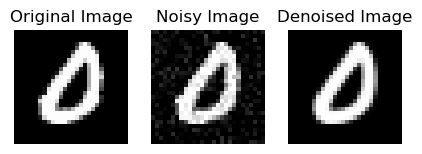

Mean Squared Error (MSE): 0.0019537194
Peak Signal-to-Noise Ratio (PSNR): 27.09137807330467
Structural Similarity Index (SSIM): 0.9771043760471108


In [114]:
image_path = input("Enter path to your image file: ")
img = image.load_img(image_path, target_size=(28, 28), color_mode='grayscale')
img_array = image.img_to_array(img)
img_array /= 255.
img_array = np.expand_dims(img_array, axis=0)

noise_factor = 0.1
noisy_img_array = add_gaussian_noise(img_array, noise_factor=noise_factor)
#noisy_img_array = add_salt_and_pepper_noise(img_array, noise_amount=0.05)

denoised_img_array = autoencoder.predict(noisy_img_array)

plt.figure(figsize=(5, 4))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(img_array.reshape(28, 28), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Noisy Image')
plt.imshow(noisy_img_array.reshape(28, 28), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Denoised Image')
plt.imshow(denoised_img_array.reshape(28, 28), cmap='gray')
plt.axis('off')

plt.show()

mse = mean_squared_error(img_array.flatten(), denoised_img_array.flatten())
psnr = 10 * np.log10(1.0 / mse)
ssim_score = ssim(img_array.squeeze(), denoised_img_array.squeeze(), data_range=1.0)

print("Mean Squared Error (MSE):", mse)
print("Peak Signal-to-Noise Ratio (PSNR):", psnr)
print("Structural Similarity Index (SSIM):", ssim_score)


In [122]:
# For Inverting an image

import cv2
image = cv2.imread(r"C:\Users\HP\OneDrive\Desktop\im10.png")
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
inverted_image = cv2.bitwise_not(gray_image)
cv2.imshow('',inverted_image)
cv2.waitKey(0)
cv2.imwrite(r"C:\Users\HP\Downloads\inverted_image.jpg", inverted_image)

True